# Basic Model plus Augmetation

## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

In [3]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

np.random.seed(42)
tf.random.set_seed(42);

import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import matplotlib.gridspec as gridspec

## ⏳ Load the Data

In [ ]:
# Load the training data here
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [ ]:
class_name = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [ ]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state=seed
)

<h3> Data Normalization and Encoding </h3>
<hr>

In [ ]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (11144, 96, 96, 3)
Training Label Shape: (11144, 8)
Validation Data Shape: (1239, 96, 96, 3)
Validation Label Shape: (1239, 8)


In [ ]:
# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))
print('Classification: ', class_name[np.argmax(y_train[0])])

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0.]
"Default" label: 0
Classification:  Basophil


<h3> Input and Output Shape </h3>
<hr>

In [ ]:
# Determine the input shape, corresponding to the number of features
input_shape = X_train.shape[1:]
print(f'Input shape of the network {input_shape}')

# Determine the output shape, corresponding to the number of classes
output_shape = y_train.shape[1]
print(f'Output shape of the network {output_shape}')

Input shape of the network (96, 96, 3)
Output shape of the network 8


<h3> Other Parameters Definition </h3>
<hr>

In [ ]:
# Learning rate?: step size for updating the model's weights
learning_rate = 0.001

# Define the batch size for training
batch_size = 64

# Define the number of training epochs
epochs = 1000

# Create an empty dictionary to store metadata
metadata = {}

## 🛠️ Train and Save the Model

In [ ]:
tf.random.set_seed(seed)

# Build the neural network layer by layer
inputs = tfkl.Input(shape=input_shape, name='Input')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
#    tfkl.RandomBrightness(0.5, value_range=(0,1)),
#    tfkl.RandomContrast(0.75),
], name='Augmentation')

x = augmentation(inputs)

x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs)
x = tfkl.Activation('relu', name='act1')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
x = tfkl.Activation('relu', name='act2')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

x = tfkl.Flatten(name='flatten')(x)

x = tfkl.Dense(units=output_shape, name='dense')(x)
outputs = tfkl.Activation('softmax', name='softmax')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs, name='02-AdditionOfAugmentation')

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 36864)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │       294,920 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

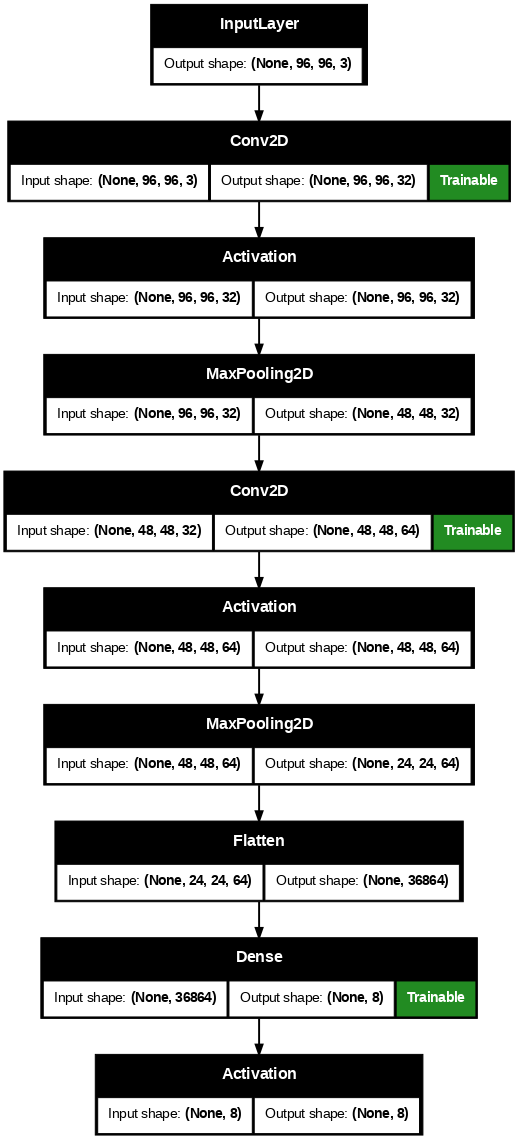

In [ ]:
# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BLOOD_CNN_TEST_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4447 - loss: 1.5412 - val_accuracy: 0.7272 - val_loss: 0.8008
Epoch 2/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7411 - loss: 0.7298 - val_accuracy: 0.7885 - val_loss: 0.6089
Epoch 3/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7994 - loss: 0.5736 - val_accuracy: 0.7990 - val_loss: 0.5698
Epoch 4/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8160 - loss: 0.5074 - val_accuracy: 0.8111 - val_loss: 0.5235
Epoch 5/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8301 - loss: 0.4659 - val_accuracy: 0.8208 - val_loss: 0.4976
Epoch 6/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8411 - loss: 0.4380 - val_accuracy: 0.8184 - val_loss: 0.5018
Epoch 7/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8458 - loss: 0.4208 - val_accuracy: 0.8152 - val_loss: 0.5028
Epoch 8/1000
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8529 - loss: 0

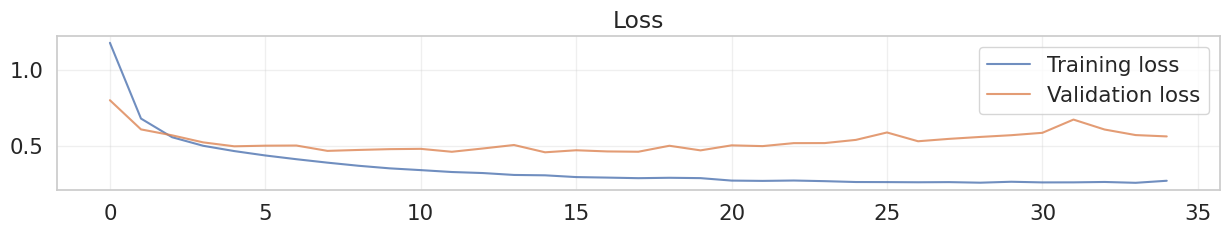

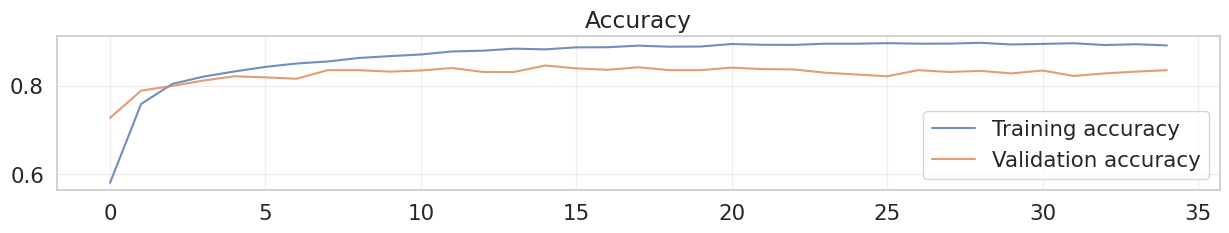

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

<h3> Model Analysis </h3>
<hr>

In [ ]:
# Load the saved model
model = tfk.models.load_model('BLOOD_CNN_TEST_84.5.keras')

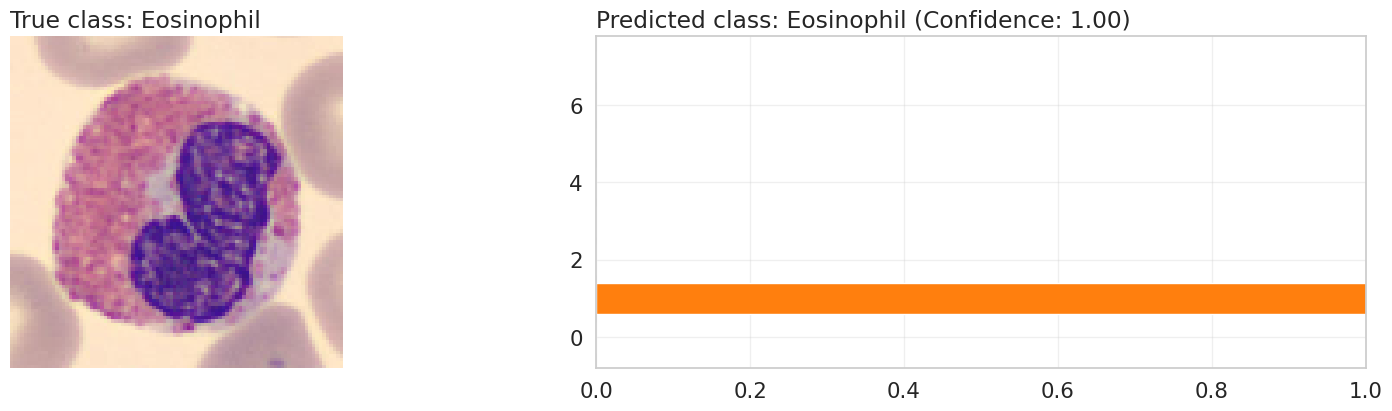

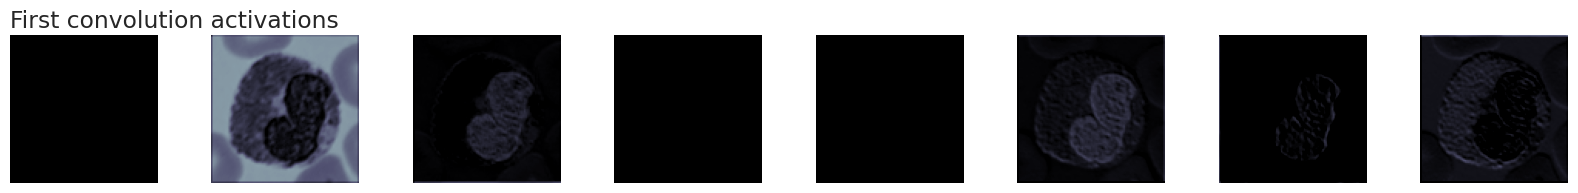

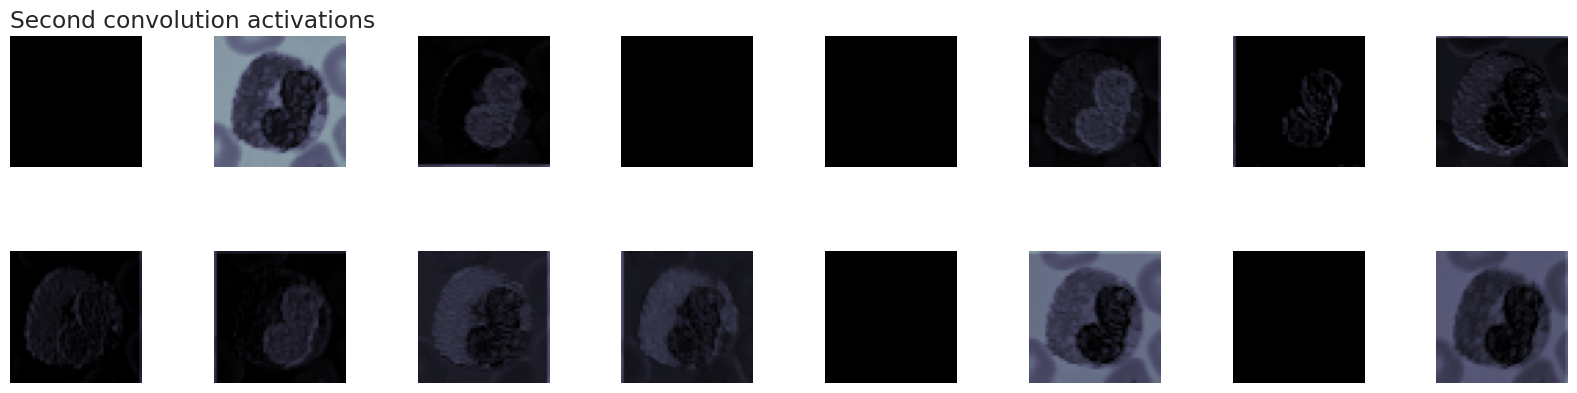

In [ ]:
def extract_activations(model, X, num_images):

    # Identify the first convolutional layer
    first_conv_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            first_conv_index = i
            break

    if first_conv_index is None:
        raise ValueError("The model does not contain a 2D convolution")

    # Extract activations from the first convolutional layer
    first_conv = tfk.Sequential(model.layers[:first_conv_index + 1])
    first_activations = first_conv(X[:num_images])

    # Identify the first pooling layer after the first convolution
    pooling_index = None
    for i, layer in enumerate(model.layers[first_conv_index + 1:], start=first_conv_index + 1):
        if isinstance(layer, (tfk.layers.MaxPooling2D, tfk.layers.AveragePooling2D)):
            pooling_index = i
            break

    if pooling_index is None:
        raise ValueError("The model does not contain a 2D pooling operation after the first convolution")

    # Extract activations from the first convolution and the first pooling layer
    second_conv = tfk.Sequential(model.layers[:pooling_index + 1])
    second_activations = second_conv(X[:num_images])

    return first_activations, second_activations

def find_last_conv_layer(model):

    # Identify the last convolutional layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def visualize(model, X, y, unique_labels, num_images=50, display_activations=True):

    # Extract activations from the model
    first_activations, second_activations = extract_activations(model, X, num_images)

    # Select a random image for prediction and visualisation
    image = np.random.randint(0, num_images)
    predictions = model.predict(np.expand_dims(X[image], axis=0), verbose=0)
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Create figure layout for displaying the image and predictions
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display the selected image with the true class
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {unique_labels[np.argmax(y[image])]}", loc='left')
    if X[image].shape[-1] == 1:
        ax1.imshow(np.squeeze(X[image]), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(X[image]), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display the prediction bar
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(list(class_name.keys()), np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions, axis=0)):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)

    plt.show()

    # Display activations if required
    if display_activations:
        # Visualise the activations from the first convolutional layer
        fig, axes = plt.subplots(1, 8, figsize=(16, 14))
        for i in range(8):
            ax = axes[i]
            ax.imshow(first_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('First convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

        # Visualise the activations from the first pooling layer
        fig, axes = plt.subplots(2, 8, figsize=(16, 5))
        for i in range(16):
            ax = axes[i // 8, i % 8]
            ax.imshow(second_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('Second convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

# Example usage
visualize(model, X_test, y_test, class_name, display_activations=True)

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1376, 8)


Accuracy score over the test set: 0.8241
Precision score over the test set: 0.8723
Recall score over the test set: 0.8241
F1 score over the test set: 0.8363


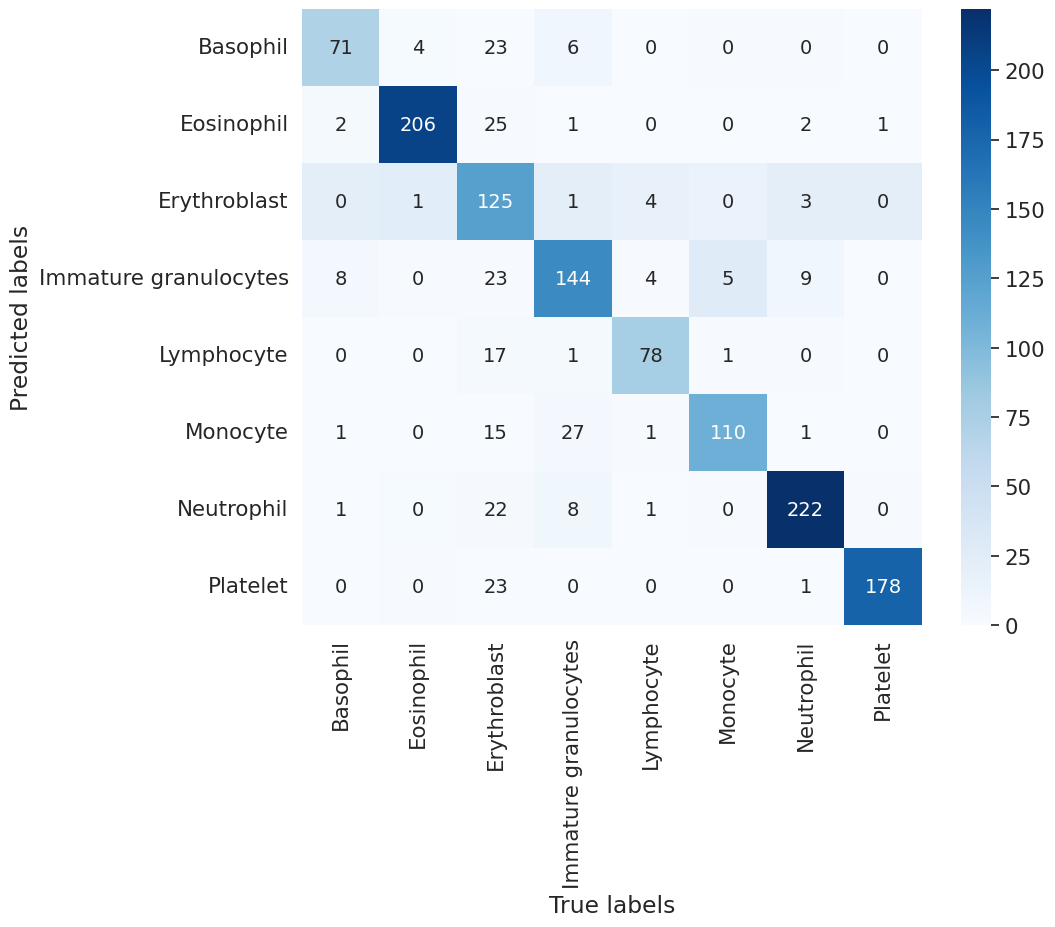

In [ ]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_name.values()), yticklabels=list(class_name.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Basic Model on Balanced Dataset plus Augmetation (up sampling)

## ⏳ Load the Data

In [4]:
# Load the training data here
data = np.load('increased_balanced_dataset_noBrightness_noContrast_noZoom.npz')
X = data['images']
y = data['labels']

In [5]:
class_name = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [6]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state=seed
)

<h3> Data Normalization and Encoding </h3>
<hr>

In [7]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [8]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (15277, 96, 96, 3)
Training Label Shape: (15277, 8)
Validation Data Shape: (1698, 96, 96, 3)
Validation Label Shape: (1698, 8)


In [9]:
# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))
print('Classification: ', class_name[np.argmax(y_train[0])])

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0.]
"Default" label: 0
Classification:  Basophil


<h3> Input and Output Shape </h3>
<hr>

In [10]:
# Determine the input shape, corresponding to the number of features
input_shape = X_train.shape[1:]
print(f'Input shape of the network {input_shape}')

# Determine the output shape, corresponding to the number of classes
output_shape = y_train.shape[1]
print(f'Output shape of the network {output_shape}')

Input shape of the network (96, 96, 3)
Output shape of the network 8


<h3> Other Parameters Definition </h3>
<hr>

In [11]:
# Learning rate?: step size for updating the model's weights
learning_rate = 0.001

# Define the batch size for training
batch_size = 64

# Define the number of training epochs
epochs = 1000

# Create an empty dictionary to store metadata
metadata = {}

## 🛠️ Train and Save the Model

In [12]:
tf.random.set_seed(seed)

# Build the neural network layer by layer
inputs = tfkl.Input(shape=input_shape, name='Input')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
#    tfkl.RandomBrightness(0.5, value_range=(0,1)),
#    tfkl.RandomContrast(0.75),
], name='Augmentation')

x = augmentation(inputs)

x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs)
x = tfkl.Activation('relu', name='act1')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
x = tfkl.Activation('relu', name='act2')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

x = tfkl.Flatten(name='flatten')(x)

x = tfkl.Dense(units=output_shape, name='dense')(x)
outputs = tfkl.Activation('softmax', name='softmax')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs, name='02-AdditionOfAugmentation')

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "02-AdditionOfAugmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 36864)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │       294,920 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

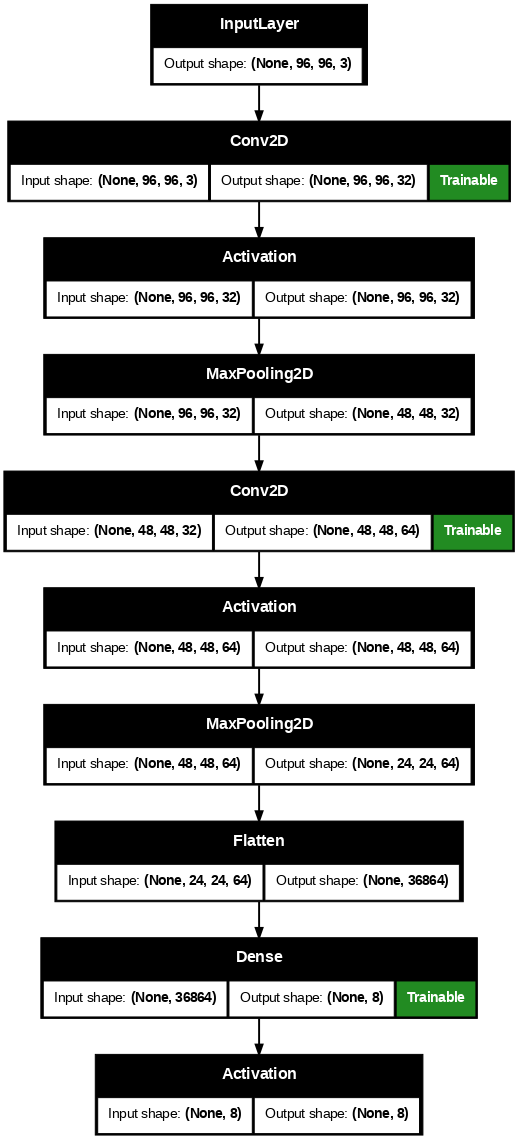

In [13]:
# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [14]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [15]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BLOOD_CNN_TEST_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.3871 - loss: 1.6480 - val_accuracy: 0.7067 - val_loss: 0.8685
Epoch 2/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6908 - loss: 0.8677 - val_accuracy: 0.7450 - val_loss: 0.7014
Epoch 3/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7653 - loss: 0.6592 - val_accuracy: 0.7774 - val_loss: 0.6191
Epoch 4/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7907 - loss: 0.5839 - val_accuracy: 0.7868 - val_loss: 0.6037
Epoch 5/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8130 - loss: 0.5237 - val_accuracy: 0.7903 - val_loss: 0.6049
Epoch 6/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8277 - loss: 0.4780 - val_accuracy: 0.8045 - val_loss: 0.5652
Epoch 7/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8451 - loss: 0.4387 - val_accuracy: 0.8127 - val_loss: 0.5388
Epoch 8/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8525 - loss: 

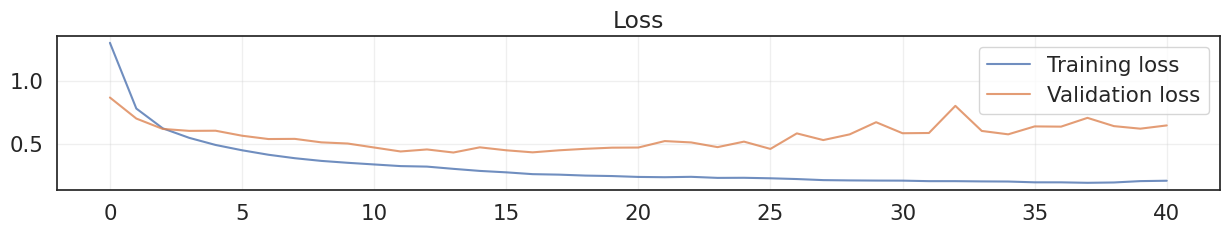

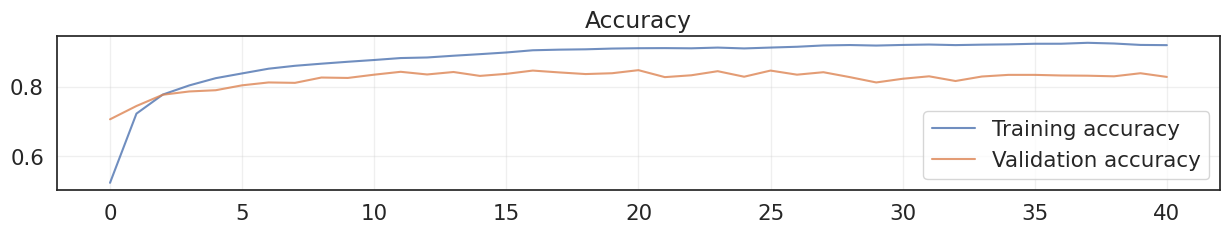

In [16]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

<h3> Model Analysis </h3>
<hr>

In [17]:
# Load the saved model
model = tfk.models.load_model('BLOOD_CNN_TEST_84.81.keras')

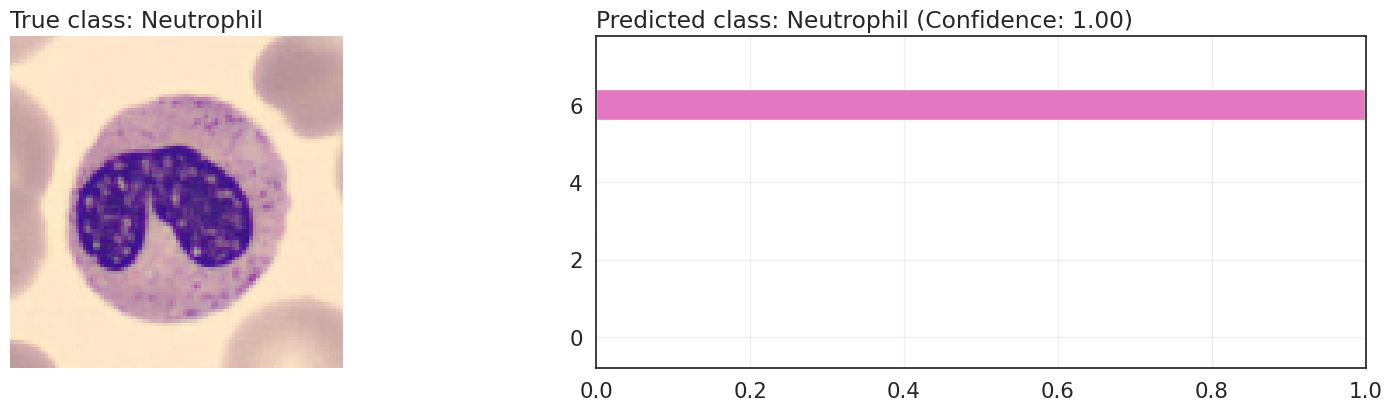

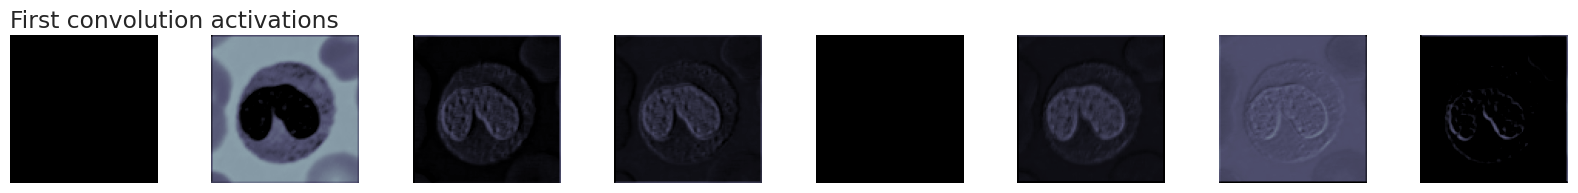

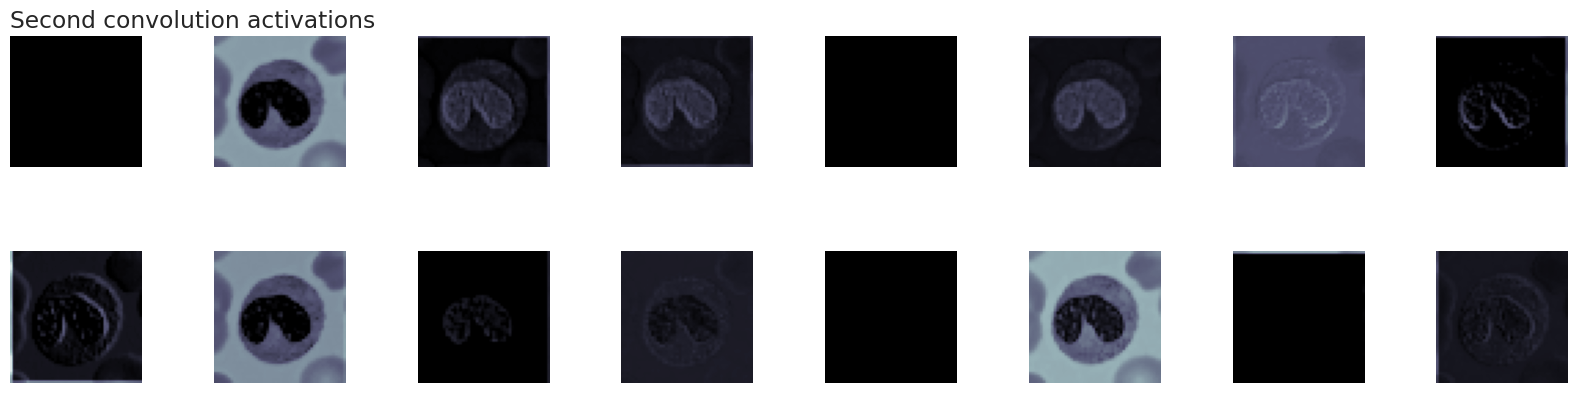

In [18]:
def extract_activations(model, X, num_images):

    # Identify the first convolutional layer
    first_conv_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            first_conv_index = i
            break

    if first_conv_index is None:
        raise ValueError("The model does not contain a 2D convolution")

    # Extract activations from the first convolutional layer
    first_conv = tfk.Sequential(model.layers[:first_conv_index + 1])
    first_activations = first_conv(X[:num_images])

    # Identify the first pooling layer after the first convolution
    pooling_index = None
    for i, layer in enumerate(model.layers[first_conv_index + 1:], start=first_conv_index + 1):
        if isinstance(layer, (tfk.layers.MaxPooling2D, tfk.layers.AveragePooling2D)):
            pooling_index = i
            break

    if pooling_index is None:
        raise ValueError("The model does not contain a 2D pooling operation after the first convolution")

    # Extract activations from the first convolution and the first pooling layer
    second_conv = tfk.Sequential(model.layers[:pooling_index + 1])
    second_activations = second_conv(X[:num_images])

    return first_activations, second_activations

def find_last_conv_layer(model):

    # Identify the last convolutional layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def visualize(model, X, y, unique_labels, num_images=50, display_activations=True):

    # Extract activations from the model
    first_activations, second_activations = extract_activations(model, X, num_images)

    # Select a random image for prediction and visualisation
    image = np.random.randint(0, num_images)
    predictions = model.predict(np.expand_dims(X[image], axis=0), verbose=0)
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Create figure layout for displaying the image and predictions
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display the selected image with the true class
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {unique_labels[np.argmax(y[image])]}", loc='left')
    if X[image].shape[-1] == 1:
        ax1.imshow(np.squeeze(X[image]), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(X[image]), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display the prediction bar
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(list(class_name.keys()), np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions, axis=0)):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)

    plt.show()

    # Display activations if required
    if display_activations:
        # Visualise the activations from the first convolutional layer
        fig, axes = plt.subplots(1, 8, figsize=(16, 14))
        for i in range(8):
            ax = axes[i]
            ax.imshow(first_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('First convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

        # Visualise the activations from the first pooling layer
        fig, axes = plt.subplots(2, 8, figsize=(16, 5))
        for i in range(16):
            ax = axes[i // 8, i % 8]
            ax.imshow(second_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('Second convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

# Example usage
visualize(model, X_test, y_test, class_name, display_activations=True)

In [19]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1887, 8)


Accuracy score over the test set: 0.8225
Precision score over the test set: 0.8498
Recall score over the test set: 0.8225
F1 score over the test set: 0.8269


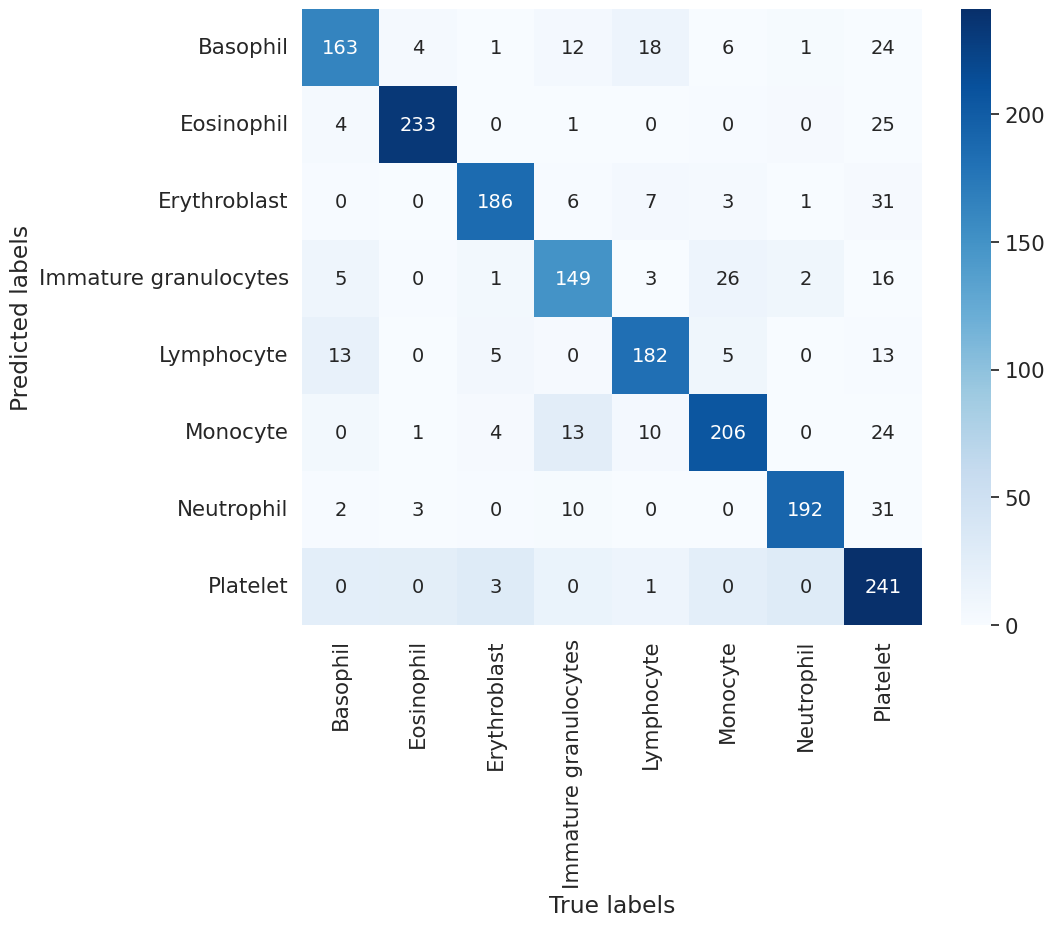

In [20]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_name.values()), yticklabels=list(class_name.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Basic Model on Balanced Dataset plus Augmetation (down sampling)

## ⏳ Load the Data

In [22]:
# Load the training data here
data = np.load('reduced_balanced_dataset.npz')
X = data['images']
y = data['lables']

In [23]:
class_name = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [24]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state=seed
)

<h3> Data Normalization and Encoding </h3>
<hr>

In [25]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [26]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (6908, 96, 96, 3)
Training Label Shape: (6908, 8)
Validation Data Shape: (768, 96, 96, 3)
Validation Label Shape: (768, 8)


In [27]:
# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))
print('Classification: ', class_name[np.argmax(y_train[0])])

Categorical label: [0. 0. 0. 0. 1. 0. 0. 0.]
"Default" label: 4
Classification:  Lymphocyte


<h3> Input and Output Shape </h3>
<hr>

In [28]:
# Determine the input shape, corresponding to the number of features
input_shape = X_train.shape[1:]
print(f'Input shape of the network {input_shape}')

# Determine the output shape, corresponding to the number of classes
output_shape = y_train.shape[1]
print(f'Output shape of the network {output_shape}')

Input shape of the network (96, 96, 3)
Output shape of the network 8


<h3> Other Parameters Definition </h3>
<hr>

In [29]:
# Learning rate?: step size for updating the model's weights
learning_rate = 0.001

# Define the batch size for training
batch_size = 64

# Define the number of training epochs
epochs = 1000

# Create an empty dictionary to store metadata
metadata = {}

## 🛠️ Train and Save the Model

In [30]:
tf.random.set_seed(seed)

# Build the neural network layer by layer
inputs = tfkl.Input(shape=input_shape, name='Input')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
#    tfkl.RandomBrightness(0.5, value_range=(0,1)),
#    tfkl.RandomContrast(0.75),
], name='Augmentation')

x = augmentation(inputs)

x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs)
x = tfkl.Activation('relu', name='act1')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
x = tfkl.Activation('relu', name='act2')(x)
x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

x = tfkl.Flatten(name='flatten')(x)

x = tfkl.Dense(units=output_shape, name='dense')(x)
outputs = tfkl.Activation('softmax', name='softmax')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs, name='02-AdditionOfAugmentation')

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [31]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [32]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BLOOD_CNN_TEST_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.2830 - loss: 1.8727 - val_accuracy: 0.5977 - val_loss: 1.2251
Epoch 2/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5768 - loss: 1.1665 - val_accuracy: 0.7018 - val_loss: 0.8736
Epoch 3/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6804 - loss: 0.8786 - val_accuracy: 0.7279 - val_loss: 0.7630
Epoch 4/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7171 - loss: 0.7568 - val_accuracy: 0.7643 - val_loss: 0.6879
Epoch 5/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7401 - loss: 0.7019 - val_accuracy: 0.7552 - val_loss: 0.6829
Epoch 6/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7548 - loss: 0.6653 - val_accuracy: 0.7643 - val_loss: 0.6448
Epoch 7/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7646 - loss: 0.6329 - val_accuracy: 0.7669 - val_loss: 0.6193
Epoch 8/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7721 - loss: 0

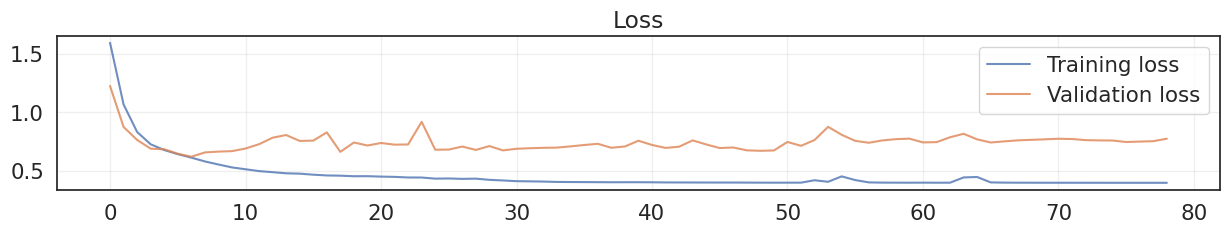

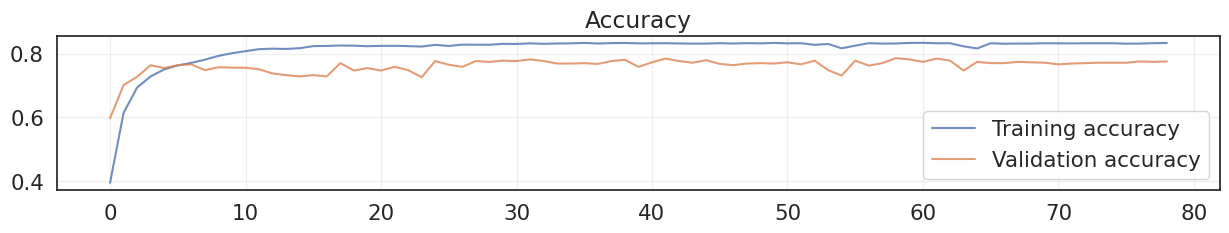

In [33]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

<h3> Model Analysis </h3>
<hr>

In [34]:
# Load the saved model
model = tfk.models.load_model('BLOOD_CNN_TEST_78.65.keras')

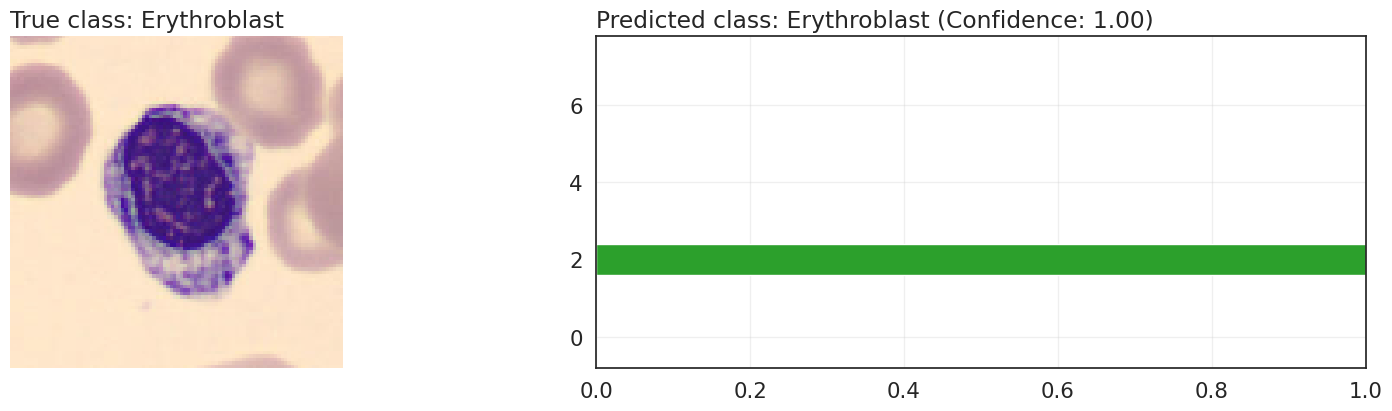

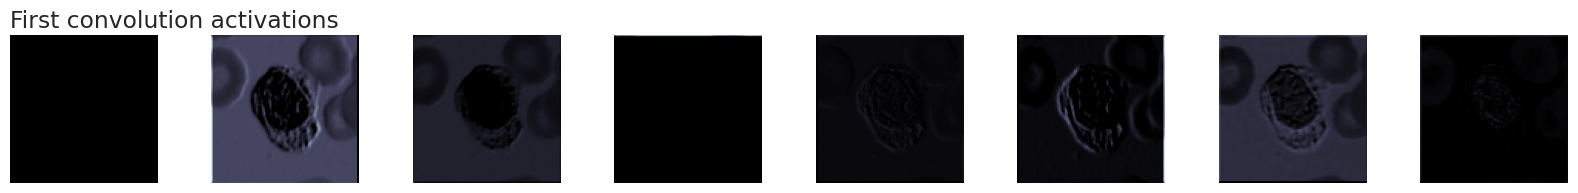

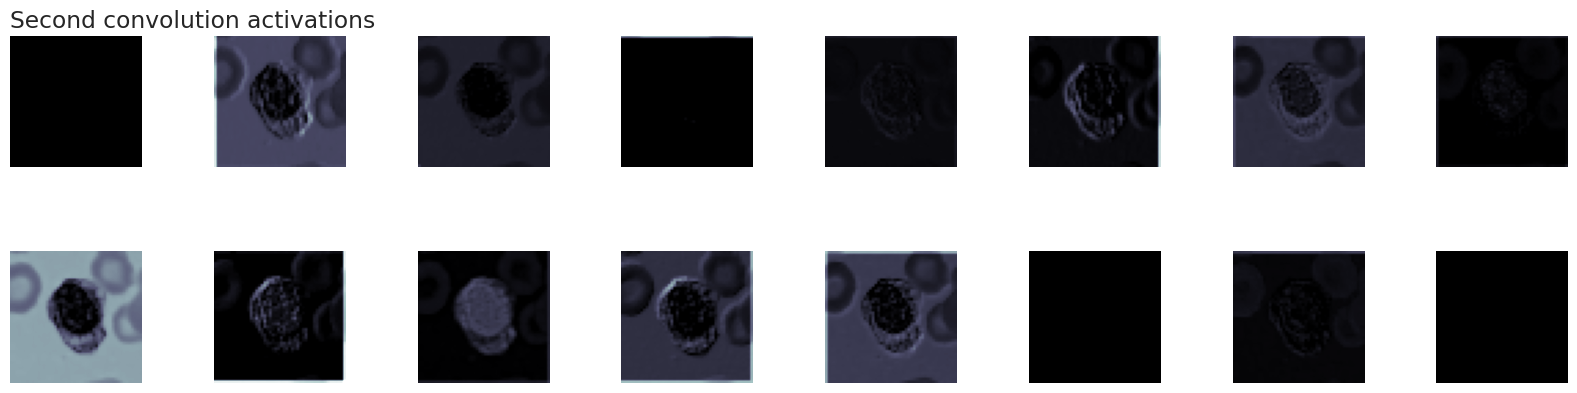

In [35]:
def extract_activations(model, X, num_images):

    # Identify the first convolutional layer
    first_conv_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            first_conv_index = i
            break

    if first_conv_index is None:
        raise ValueError("The model does not contain a 2D convolution")

    # Extract activations from the first convolutional layer
    first_conv = tfk.Sequential(model.layers[:first_conv_index + 1])
    first_activations = first_conv(X[:num_images])

    # Identify the first pooling layer after the first convolution
    pooling_index = None
    for i, layer in enumerate(model.layers[first_conv_index + 1:], start=first_conv_index + 1):
        if isinstance(layer, (tfk.layers.MaxPooling2D, tfk.layers.AveragePooling2D)):
            pooling_index = i
            break

    if pooling_index is None:
        raise ValueError("The model does not contain a 2D pooling operation after the first convolution")

    # Extract activations from the first convolution and the first pooling layer
    second_conv = tfk.Sequential(model.layers[:pooling_index + 1])
    second_activations = second_conv(X[:num_images])

    return first_activations, second_activations

def find_last_conv_layer(model):

    # Identify the last convolutional layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def visualize(model, X, y, unique_labels, num_images=50, display_activations=True):

    # Extract activations from the model
    first_activations, second_activations = extract_activations(model, X, num_images)

    # Select a random image for prediction and visualisation
    image = np.random.randint(0, num_images)
    predictions = model.predict(np.expand_dims(X[image], axis=0), verbose=0)
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Create figure layout for displaying the image and predictions
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display the selected image with the true class
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {unique_labels[np.argmax(y[image])]}", loc='left')
    if X[image].shape[-1] == 1:
        ax1.imshow(np.squeeze(X[image]), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(X[image]), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display the prediction bar
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(list(class_name.keys()), np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions, axis=0)):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)

    plt.show()

    # Display activations if required
    if display_activations:
        # Visualise the activations from the first convolutional layer
        fig, axes = plt.subplots(1, 8, figsize=(16, 14))
        for i in range(8):
            ax = axes[i]
            ax.imshow(first_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('First convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

        # Visualise the activations from the first pooling layer
        fig, axes = plt.subplots(2, 8, figsize=(16, 5))
        for i in range(16):
            ax = axes[i // 8, i % 8]
            ax.imshow(second_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('Second convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

# Example usage
visualize(model, X_test, y_test, class_name, display_activations=True)

In [36]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (853, 8)


Accuracy score over the test set: 0.7796
Precision score over the test set: 0.8514
Recall score over the test set: 0.7796
F1 score over the test set: 0.7963


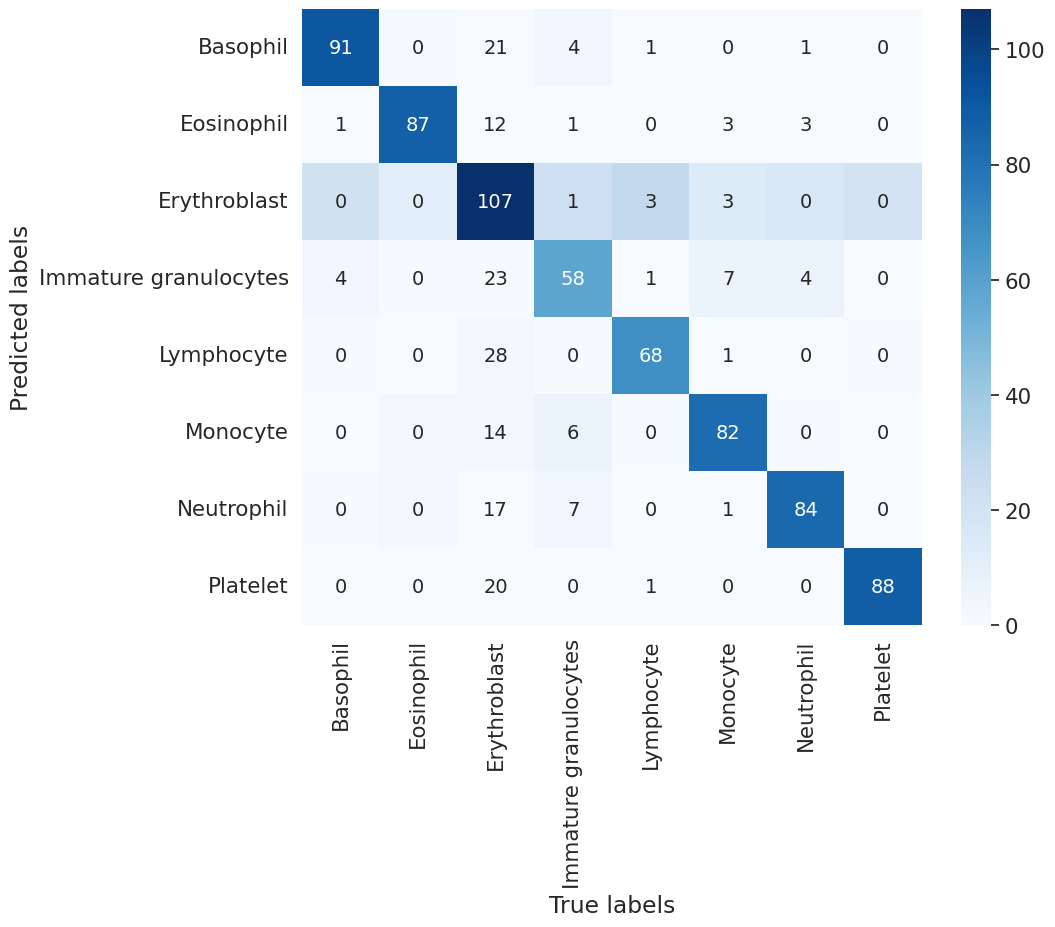

In [37]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_name.values()), yticklabels=list(class_name.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

<hr>